# Hall of Fame Prediction

Was interested in seeing if a player were to retire today or were eligible for the MLB HOF, either for the first time or again, what would their probabilities look like if it weren't voted on by people but rather Machine Learning in comparison with already inducted players. I took the data from a very useful website with baseball stats called: https://www.seanlahman.com/baseball-archive/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Convert files to dataframe

In [2]:
master_df = pd.read_csv('People.csv', usecols = ['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'finalGame'])
fielding_df = pd.read_csv('Fielding.csv', usecols = ['playerID','A','E','DP'])
pitching_df = pd.read_csv('Pitching.csv', usecols = ['playerID','W','L','CG','SHO','SV','IPouts','H', 'ER','HR','BB','SO','BFP'])

teams_df = pd.read_csv('Teams.csv')
award_df = pd.read_csv('AwardsPlayers.csv', usecols = ['playerID','awardID','yearID'])
allstar_df = pd.read_csv('AllstarFull.csv', usecols = ['playerID','yearID'])
hof_df = pd.read_csv('HallOfFame.csv', usecols = ['playerID','yearID', 'inducted','category'])
appearances_df = pd.read_csv('Appearances.csv')

In [3]:
hof_df.head()

,playerID,yearID,inducted,category
0,cobbty01,1936,Y,Player
1,ruthba01,1936,Y,Player
2,wagneho01,1936,Y,Player
3,mathech01,1936,Y,Player
4,johnswa01,1936,Y,Player


Separate out the players already in the Hall of Fame

In [4]:
hall = hof_df[(hof_df['category'] == 'Player') & (hof_df['inducted'] == 'Y')]
hall = hall.drop(['category', 'yearID'], axis = 1)

hall['inducted'] = 1

In [5]:
hall.head()

,playerID,inducted
0,cobbty01,1
1,ruthba01,1
2,wagneho01,1
3,mathech01,1
4,johnswa01,1


Combine Pitching Stats for Career Numbers

In [6]:
pitching = pitching_df.groupby('playerID', as_index = False).sum()
pitching = pitching.fillna(0)
pitching['ERA'] = (9 * pitching['ER']) / (pitching['IPouts'] / 3)
pitching.head()


,playerID,W,L,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BFP,ERA
0,aardsda01,16,18,0,0,69,1011,296,160,41,183,340,1475.0,4.272997
1,aasedo01,66,60,22,5,82,3328,1085,468,89,457,641,4730.0,3.796875
2,abadfe01,8,29,0,0,2,1045,332,146,43,123,290,1481.0,3.772249
3,abbeybe01,22,40,52,0,1,1704,686,285,18,192,161,2568.0,4.515845
4,abbeych01,0,0,0,0,0,6,6,1,0,0,0,12.0,4.500000


Combine Fielding Stats for Career Numbers

In [7]:
fielding = fielding_df.groupby('playerID', as_index = False).sum()
fielding = fielding.fillna(0)
fielding.head()

,playerID,A,E,DP
0,aardsda01,29,3.0,2
1,aaronha01,429,144.0,218
2,aaronto01,113,22.0,124
3,aasedo01,135,13.0,10
4,abadan01,1,1.0,3


Count the number of total All Star Appearances

In [8]:
allstar = allstar_df.groupby('playerID').count()
allstar.rename(columns = {'yearID':'All Star Count'}, inplace = True)
allstar.head()

,All Star Count
playerID,
aaronha01,24
aasedo01,1
abreubo01,2
abreujo02,3
acunaro01,2


Weed Out relevant Awards

In [9]:
award_df['awardID'].unique()

array(['Pitching Triple Crown', 'Triple Crown',
       'Baseball Magazine All-Star', 'Most Valuable Player',
       'TSN All-Star', 'TSN Guide MVP',
       'TSN Major League Player of the Year', 'TSN Pitcher of the Year',
       'TSN Player of the Year', 'Rookie of the Year', 'Babe Ruth Award',
       'Lou Gehrig Memorial Award', 'World Series MVP', 'Cy Young Award',
       'Gold Glove', 'TSN Fireman of the Year', 'All-Star Game MVP',
       'Hutch Award', 'Roberto Clemente Award',
       'Rolaids Relief Man Award', 'NLCS MVP', 'ALCS MVP',
       'Silver Slugger', 'Branch Rickey Award', 'Hank Aaron Award',
       'TSN Reliever of the Year', 'Comeback Player of the Year',
       'Outstanding DH Award', 'Reliever of the Year Award',
       'SIlver Slugger'], dtype=object)

In [10]:
important_awards = ['Pitching Triple Crown', 'Most Valuable Player','Rookie of the Year','World Series MVP','Cy Young Award','Gold Glove','Rolaids Relief Man Award','Reliever of the Year Award']
awards = award_df[award_df['awardID'].isin(important_awards)]

awards = awards.pivot_table(index = 'playerID', columns = 'awardID', aggfunc='count')
awards = pd.DataFrame(awards.to_records())

awards.columns = [col.replace("('yearID', '", "") for col in awards.columns]
awards.columns = [col.replace("')", "") for col in awards.columns]
awards.head()

,playerID,Cy Young Award,Gold Glove,Most Valuable Player,Pitching Triple Crown,Reliever of the Year Award,Rolaids Relief Man Award,Rookie of the Year,World Series MVP
0,aaronha01,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,abreubo01,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,abreujo02,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
3,acunaro01,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,ageeto01,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN


Combine All Stats from above into one dataframe

In [11]:
career_stats = pitching.merge(fielding, on = "playerID", how = "left")
career_stats = career_stats.merge(allstar, on = "playerID", how = "left")
career_stats = career_stats.merge(awards, on = "playerID", how = "left")
career_stats = career_stats.merge(hall, on = "playerID", how = "left")
career_stats = career_stats.fillna(0)

career_stats.head()

,playerID,W,L,CG,SHO,SV,IPouts,H,ER,HR,...,All Star Count,Cy Young Award,Gold Glove,Most Valuable Player,Pitching Triple Crown,Reliever of the Year Award,Rolaids Relief Man Award,Rookie of the Year,World Series MVP,inducted
0,aardsda01,16,18,0,0,69,1011,296,160,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aasedo01,66,60,22,5,82,3328,1085,468,89,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abadfe01,8,29,0,0,2,1045,332,146,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abbeybe01,22,40,52,0,1,1704,686,285,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abbeych01,0,0,0,0,0,6,6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Filter finalGame so that it only has the the year

In [12]:
master_df.head()

,playerID,nameFirst,nameLast,bats,throws,finalGame
0,aardsda01,David,Aardsma,R,R,2015-08-23
1,aaronha01,Hank,Aaron,R,R,1976-10-03
2,aaronto01,Tommie,Aaron,R,R,1971-09-26
3,aasedo01,Don,Aase,R,R,1990-10-03
4,abadan01,Andy,Abad,L,L,2006-04-13


In [13]:
from datetime import datetime

def getYear(datestring):
    return datetime.strptime(datestring, '%Y-%m-%d').year

master = master_df.dropna(subset = ['finalGame'])

# Get years from strings
master['final'] = master['finalGame'].map(getYear)
master = master.drop('finalGame', axis = 1)

master.head()


C:\Users\qbend\AppData\Local\Temp\ipykernel_30772\1356072903.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['final'] = master['finalGame'].map(getYear)


,playerID,nameFirst,nameLast,bats,throws,final
0,aardsda01,David,Aardsma,R,R,2015
1,aaronha01,Hank,Aaron,R,R,1976
2,aaronto01,Tommie,Aaron,R,R,1971
3,aasedo01,Don,Aase,R,R,1990
4,abadan01,Andy,Abad,L,L,2006


In [14]:
appearances_df.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,1.0,1,1.0,0,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
1,1871,RC1,NaN,addybo01,25,25.0,25,25.0,0,0,...,22,0,3,0,0,0,0,0.0,0.0,0.0
2,1871,CL1,NaN,allisar01,29,29.0,29,29.0,0,0,...,2,0,0,0,29,0,29,0.0,0.0,0.0
3,1871,WS3,NaN,allisdo01,27,27.0,27,27.0,0,27,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,1871,RC1,NaN,ansonca01,25,25.0,25,25.0,0,5,...,2,20,0,1,0,0,1,0.0,0.0,0.0


In [15]:
appearances = appearances_df.drop(['G_ph', 'G_pr'], axis = 1)
appearances = appearances.groupby(['playerID'], as_index = False).sum()
appearances = appearances.fillna(0)

appearances.head()

,playerID,yearID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh
0,aardsda01,18084,331,0.0,139,331.0,331,0,0,0,0,0,0,0,0,0,0.0
1,aaronha01,45195,3298,3173.0,3298,2985.0,0,0,210,43,7,0,315,308,2174,2760,201.0
2,aaronto01,13768,437,206.0,437,346.0,0,0,232,7,10,0,135,1,2,137,0.0
3,aasedo01,25786,448,91.0,81,448.0,448,0,0,0,0,0,0,0,0,0,0.0
4,abadan01,6010,15,4.0,15,9.0,0,0,8,0,0,0,0,0,1,1,0.0


Weed out players who didn't play at least 10% of games as a pitcher

In [16]:
pos = appearances.columns[5:]
for col in pos:
    column = col + '_percent'
    appearances[column] = appearances[col] / appearances['G_all'] 
    
appearances = appearances[(appearances['G_p_percent'] > 0.1)]

Arbitrarily decided to omit the first 20+ years of baseball because the game was very different. I chose 1897 because it was the debut year of Honus Wagner, the oldest player inducted to the Hall of Fame in the first class

In [17]:
yearly_RPG = teams_df.groupby('yearID').sum()[['G','R']] 
yearly_RPG['RPG'] = yearly_RPG['R'] / yearly_RPG['G']
yearly_RPG = yearly_RPG.loc[1897:]
yearly_RPG.head()


,G,R,RPG
yearID,,,
1897,1614,9536,5.908302
1898,1840,9129,4.961413
1899,1842,9672,5.250814
1900,1136,5932,5.221831
1901,2218,11067,4.989630


Let's see how the Runs per Game look throughout the years

Text(0, 0.5, 'Runs per game')

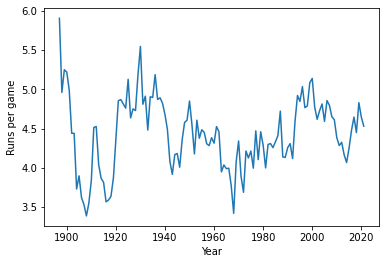

In [18]:
yearly_RPG['RPG'].plot()
plt.xlabel("Year")
plt.ylabel("Runs per game")


Add a method to count how many years you player in each era

In [19]:
era = appearances_df.copy()[['yearID','playerID','teamID']]

era = era[era['yearID'] > 1896]

def getEra(year):
    if int(year) < 1920:
        return 'Dead Ball'
    elif int(year) < 1942:
        return 'Live Ball'
    elif int(year) < 1961:
        return 'Integration'
    elif int(year) < 1977:
        return 'Expansion'
    elif int(year) < 1994:
        return 'Free Agency'
    elif int(year) < 2006:
        return 'Steroid'
    else:
        return 'Current'
    
era['yearID'] = era['yearID'].map(getEra)

era = era.pivot_table(index='playerID', columns = 'yearID', aggfunc='count')
era = pd.DataFrame(era.to_records())
era.columns = [col.replace("('teamID', '", "") for col in era.columns]
era.columns = [col.replace("')", "") for col in era.columns]
era = era.fillna(0)
era['years'] = era.sum(axis = 1)
era = era.merge(appearances, on = 'playerID', how = "inner")

era.head()


C:\Users\qbend\AppData\Local\Temp\ipykernel_30772\3044963812.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  era['years'] = era.sum(axis = 1)


,playerID,Current,Dead Ball,Expansion,Free Agency,Integration,Live Ball,Steroid,years,yearID,...,G_c_percent,G_1b_percent,G_2b_percent,G_3b_percent,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent
0,aardsda01,8.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,18084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aasedo01,0.0,0.0,0.0,13.0,0.0,0.0,0.0,13.0,25786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abadfe01,11.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,22164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abbotco01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abbotgl01,0.0,0.0,4.0,8.0,0.0,0.0,0.0,12.0,23743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merge data into a main dataframe

In [20]:
df = master.merge(career_stats, on = "playerID", how = 'left')
df = df.merge(era, on = 'playerID', how = 'inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8985 entries, 0 to 8984
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   playerID                    8985 non-null   object 
 1   nameFirst                   8985 non-null   object 
 2   nameLast                    8985 non-null   object 
 3   bats                        8868 non-null   object 
 4   throws                      8963 non-null   object 
 5   final                       8985 non-null   int64  
 6   W                           8985 non-null   float64
 7   L                           8985 non-null   float64
 8   CG                          8985 non-null   float64
 9   SHO                         8985 non-null   float64
 10  SV                          8985 non-null   float64
 11  IPouts                      8985 non-null   float64
 12  H                           8985 non-null   float64
 13  ER                          8985 

In [21]:
df.head()

,playerID,nameFirst,nameLast,bats,throws,final,W,L,CG,SHO,...,G_c_percent,G_1b_percent,G_2b_percent,G_3b_percent,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent
0,aardsda01,David,Aardsma,R,R,2015,16.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aasedo01,Don,Aase,R,R,1990,66.0,60.0,22.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abadfe01,Fernando,Abad,L,L,2021,8.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abbotco01,Cory,Abbott,R,R,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abbotgl01,Glenn,Abbott,R,R,1984,62.0,83.0,37.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Add some extra common stats for pitchers

In [22]:
df['WHIP'] = (df['H'] + df['BB']) / (df['IPouts'] / 3)
df['K%'] = df['SO'] / df['BFP']
df['BB%'] = df['BB'] / df['BFP']
df['K-BB%'] = df['SO'] / df['BB']
df = df.fillna(0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
  
df.dropna(inplace=True)
  
df.head()

,playerID,nameFirst,nameLast,bats,throws,final,W,L,CG,SHO,...,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent,WHIP,K%,BB%,K-BB%
0,aardsda01,David,Aardsma,R,R,2015,16.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.421365,0.230508,0.124068,1.857923
1,aasedo01,Don,Aase,R,R,1990,66.0,60.0,22.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.390024,0.135518,0.096617,1.402626
2,abadfe01,Fernando,Abad,L,L,2021,8.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.306220,0.195814,0.083052,2.357724
3,abbotco01,Cory,Abbott,R,R,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.788462,0.146341,0.134146,1.090909
4,abbotgl01,Glenn,Abbott,R,R,1984,62.0,83.0,37.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.366252,0.087872,0.063907,1.375000


Let's compare the stats of current Hall of Famers and players who aren't in the Hall of Fame but played at least 7 years.

C:\Users\qbend\AppData\Local\Temp\ipykernel_30772\2738068248.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hof_pitchers = df_hof[df['G_p'] > 100]


<AxesSubplot:xlabel='years', ylabel='Count'>

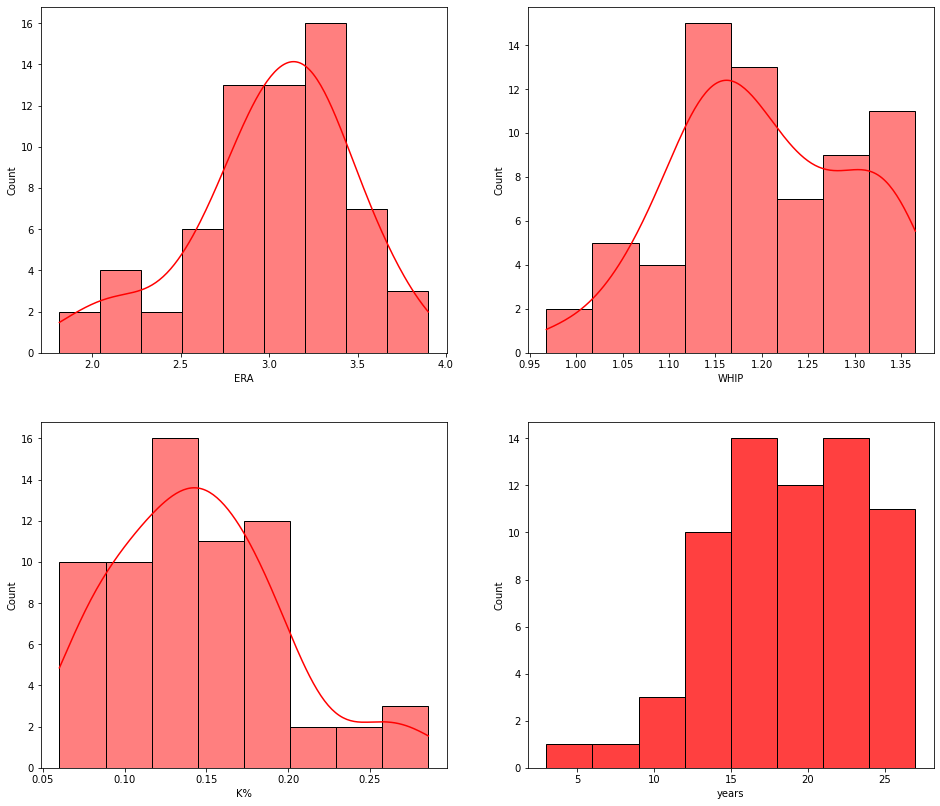

In [23]:
df_hof = df[df['inducted'] == 1]
df_hof_pitchers = df_hof[df['G_p'] > 100]

fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.histplot(df_hof_pitchers['ERA'], ax = ax1, kde = True, color = 'r')
sns.histplot(df_hof_pitchers['WHIP'], ax = ax2, kde = True, color = 'r')
sns.histplot(df_hof_pitchers['K%'], ax = ax3, kde = True, color = 'r')
sns.histplot(df_hof_pitchers['years'], ax = ax4, kde = False, color = 'r')

In [24]:
df_hof_pitchers[df_hof_pitchers['years'] < 10]

,playerID,nameFirst,nameLast,bats,throws,final,W,L,CG,SHO,...,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent,WHIP,K%,BB%,K-BB%
4076,jossad01,Addie,Joss,R,R,1910,160.0,97.0,234.0,45.0,...,0.0,0.000000,0.006757,0.000000,0.006757,0.0,0.967770,0.103475,0.040940,2.527473
5838,nichoki01,Kid,Nichols,B,R,1906,362.0,208.0,532.0,48.0,...,0.0,0.016923,0.004615,0.009231,0.030769,0.0,1.223721,0.089223,0.060336,1.478774
6079,paigesa01,Satchel,Paige,R,R,1965,28.0,31.0,7.0,4.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.279412,0.143641,0.089776,1.600000
7012,rusieam01,Amos,Rusie,R,R,1901,246.0,174.0,393.0,30.0,...,0.0,0.012320,0.002053,0.028747,0.043121,0.0,1.348624,0.119537,0.104640,1.142355


C:\Users\qbend\AppData\Local\Temp\ipykernel_30772\2950108756.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_7years_pitchers = df_7years[df['G_p'] > 50]


<AxesSubplot:xlabel='years', ylabel='Count'>

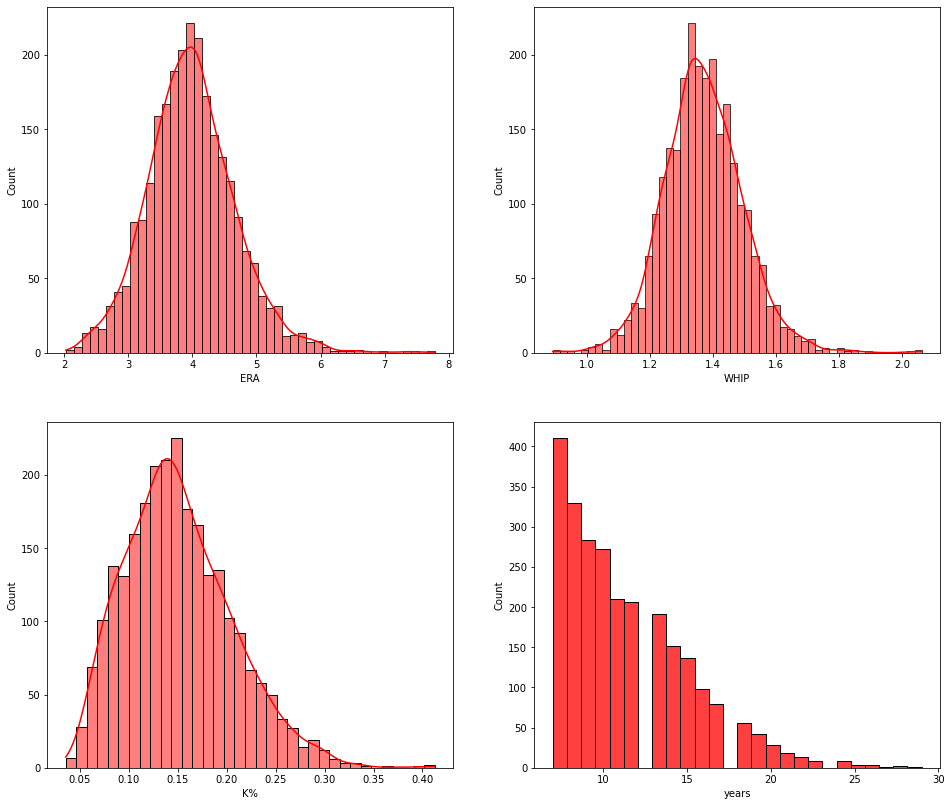

In [25]:
df_7years = df[(df['years'] >= 7) & (df['inducted'] == 0)]
df_7years_pitchers = df_7years[df['G_p'] > 50]

fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.histplot(df_7years_pitchers['ERA'], ax = ax1, kde = True, color = 'r')
sns.histplot(df_7years_pitchers['WHIP'], ax = ax2, kde = True, color = 'r')
sns.histplot(df_7years_pitchers['K%'], ax = ax3, kde = True, color = 'r')
sns.histplot(df_7years_pitchers['years'], ax = ax4, kde = False, color = 'r')



Let's look at a scatterplot of some relevant stats with HOFers and 7yr+ non-HOFers

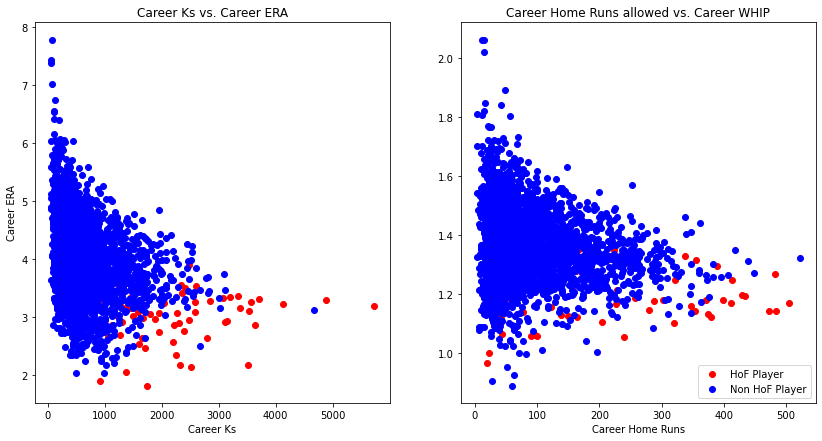

In [26]:
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
ax1.scatter(df_hof_pitchers['SO'], df_hof_pitchers['ERA'], c='r', label='HoF Player')
ax1.scatter(df_7years_pitchers['SO'], df_7years_pitchers['ERA'], c='b', label='Non HoF Player')
ax1.set_title('Career Ks vs. Career ERA')
ax1.set_xlabel('Career Ks')
ax1.set_ylabel('Career ERA')
ax2.scatter(df_hof_pitchers['HR'], df_hof_pitchers['WHIP'], c='r', label='HoF Player')
ax2.scatter(df_7years_pitchers['HR'], df_7years_pitchers['WHIP'], c='b', label='Non HoF Player')
ax2.set_title('Career Home Runs allowed vs. Career WHIP')
ax2.set_xlabel('Career Home Runs')
ax2.legend(loc='lower right', scatterpoints=1)


Let's look at a heatmap of the correlation to decide what are good factors

<AxesSubplot:>

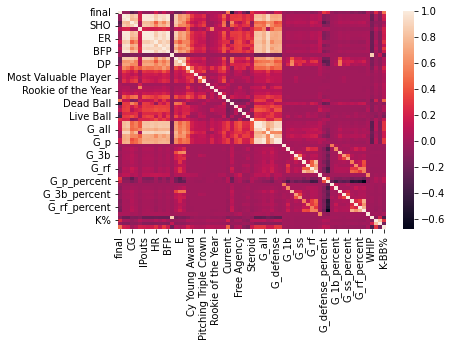

In [27]:
sns.heatmap(df.corr())

Too many stats, let's try a better way to look at this, ordered by most correlated.

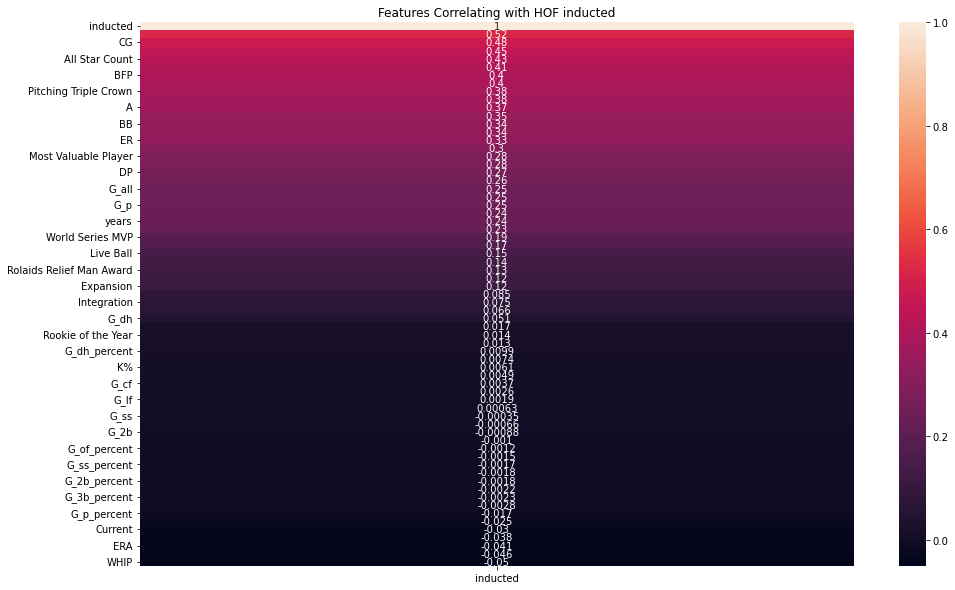

In [46]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df.corr()[['inducted']].sort_values(by='inducted', ascending=False), annot=True)
heatmap.set_title('Features Correlating with HOF inducted');

Create arbitrary cutoff of 1960 to check what players deserve a shot at the Hall, also create a df of payers already inducted

In [29]:
df_retired = df[df['final'] < 2007]

df_recent = df[df['final'] >= 1960]

early = df_recent[df_recent['inducted'] == 1]

df_recent = df_recent[df_recent['inducted'] != 1]

df_retired = df_retired.append(early)


C:\Users\qbend\AppData\Local\Temp\ipykernel_30772\3887467217.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_retired = df_retired.append(early)


In [30]:
print((df_retired['inducted'].values == 1).sum())

92


## Machine Learning

We want to target inducted and we want to train it using the most correlated stats

In [31]:
target = df_retired['inducted']
predictors = df_retired[['SHO','CG','W', 'IPouts', 'BFP', 'SO','Pitching Triple Crown','Cy Young Award','SV', 'H','L','BB','ER','HR', 'All Star Count']]

Run a train_test_split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, test_size=0.4, random_state=101)

Knew Logistic Regression was the right path, looked at what were different ways to do it and arbitrarily decided to use Random Forest Classifier.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


Kept having to update max_iter so that it would converge.

In [34]:
lr = LogisticRegression(class_weight='balanced', max_iter = 10000000)

Run the Logistic Regression Fit

In [35]:
lr.fit(X_train,Y_train)

LogisticRegression(class_weight='balanced', max_iter=10000000)

Create a pretty heavy penalty, did a lot of guess and check work to determine the n_estimators and max_depth for classifier

Through research found that cross_validate was the best method for random forest (will explain more in report.)


In [36]:
penalty = {
    0: 100,
    1: 1
}

rf = RandomForestClassifier(random_state=1,n_estimators=10, max_depth=11, min_samples_leaf=1, class_weight=penalty)

predictions_rf = cross_validate(rf, predictors, target)

rf.fit(predictors, target)


RandomForestClassifier(class_weight={0: 100, 1: 1}, max_depth=11,
                       n_estimators=10, random_state=1)

In [37]:
print(predictions_rf)

{'fit_time': array([0.15506172, 0.15029979, 0.09492588, 0.13427567, 0.13243842]), 'score_time': array([0.00700617, 0.00924921, 0.00797176, 0.00802422, 0.00970054]), 'test_score': array([0.99680511, 0.9928115 , 0.99121406, 0.99680256, 0.99280576])}


Run predictions for X_test

In [38]:
pred = rf.predict(X_test)
print(pred)

[0. 0. 0. ... 0. 0. 0.]


Let's look at the confusion matrix and classification_report

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
print(confusion_matrix(Y_test, pred))

[[2463    0]
 [   6   35]]


In [41]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2463
         1.0       1.00      0.85      0.92        41

    accuracy                           1.00      2504
   macro avg       1.00      0.93      0.96      2504
weighted avg       1.00      1.00      1.00      2504



Pretty good predictions! Very few false positives, no false negatives.

In [42]:
rf_preds = df_recent[['SHO','CG','W', 'IPouts', 'BFP', 'SO','Pitching Triple Crown','Cy Young Award','SV', 'H','L','BB','ER','HR','All Star Count']]

#Let's see who probability-wise has a good chance at the HOF
probabilities = rf.predict_proba(rf_preds)

# Let's make a new df with the probabilities
hof_preds = pd.DataFrame(probabilities[:,1])

# sort the df by prob.
hof_preds = hof_preds.sort_values(0, ascending=False)
hof_preds.rename(columns = {0:'prob'}, inplace = True)

new_data = df_recent

# Merge the prob. df with df_recent
new_data.index = range(len(new_data))
new_data.head()
hof_preds = hof_preds.join(new_data, how = 'left')
hof_preds.index = range(len(hof_preds))
hof_preds.head(50)

,prob,playerID,nameFirst,nameLast,bats,throws,final,W,L,CG,...,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent,WHIP,K%,BB%,K-BB%
0,1.000000,clemero02,Roger,Clemens,R,R,2007,354.0,184.0,118.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.172542,0.230830,0.078063,2.956962
1,1.000000,verlaju01,Justin,Verlander,R,R,2020,226.0,129.0,26.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.134203,0.246684,0.069674,3.540541
2,1.000000,scherma01,Max,Scherzer,R,R,2021,190.0,97.0,12.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.083706,0.294175,0.065946,4.460857
3,0.901316,kershcl01,Clayton,Kershaw,L,L,2021,185.0,84.0,25.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.004210,0.276197,0.062687,4.405941
4,0.900000,riverma01,Mariano,Rivera,R,R,2013,82.0,60.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000260,0.229865,0.056045,4.101399
5,0.900000,sabatcc01,CC,Sabathia,L,L,2019,251.0,161.0,38.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.258759,0.206351,0.073320,2.814377
6,0.801316,hallaro01,Roy,Halladay,R,R,2013,203.0,105.0,67.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.177740,0.187561,0.052450,3.576014
7,0.800621,schilcu01,Curt,Schilling,R,R,2007,216.0,146.0,83.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.137381,0.234568,0.053523,4.382560
8,0.800000,moyerja01,Jamie,Moyer,L,L,2012,269.0,209.0,33.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.322042,0.140643,0.066548,2.113420
9,0.700992,mussimi01,Mike,Mussina,L,R,2008,270.0,153.0,57.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.191523,0.192764,0.053793,3.583439


## Shortcomings

It's incredibly hard to predict the HOF pitchers, especially figuring out how to factor in relief pitchers. The data that is available to me is very basic stats, calculating the advanced stats is difficult, especially with older data. The data also seems to skew towards recent players more, which I'm not sure why exactly, other than presumably all players worthy and eligible for the HOF are already in.